In [1]:
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torchinfo

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset

In [2]:
def create_dataloader(dataset, transform=None, val_split=0.25, batch_size=64, num_workers=2):
    train_set = dataset('./data', train=True,  download=True, transform=transform)
    test_set  = dataset('./data', train=False, download=True, transform=transform)
    
    train_set, val_set = torch.utils.data.random_split(train_set, [1-val_split, val_split])
    
    train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val   = torch.utils.data.DataLoader(val_set,   batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    test  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return (train, val, test)

# Create model

## CNN

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_shape: Tuple[int], cnn_out_features: List[int]):
        super().__init__()
        
        self.cnn_layers = nn.ModuleList()
        shape = list(input_shape)
        prev_nf = input_shape[0]
        
        for curr_nf in cnn_out_features:
            self.cnn_layers.append(nn.Sequential(
                nn.Conv2d(prev_nf, curr_nf, kernel_size=3, padding='same'),
                nn.MaxPool2d(2)
            ))
            prev_nf = curr_nf
            
            shape[0] = curr_nf
            shape[1] = int(shape[1] / 2)
            shape[2] = int(shape[2] / 2)
        
        self.input_shape = input_shape
        self.output_shape = (shape[0], shape[1], shape[2])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.cnn_layers:
            x = layer(x)
        return x

In [4]:
class ClassRegressor(nn.Module):
    def __init__(self, input_shape: Tuple[int], output_shape: int, fnn_out_features: List[int]):
        super().__init__()
        
        if isinstance(input_shape, tuple):
            in_features = 1
            for x in input_shape:
                in_features *= x
        else:
            in_features = input_shape
        
        self.fnn_layers = nn.ModuleList()
        prev_nf = in_features
        
        for curr_nf in fnn_out_features:
            self.fnn_layers.append(nn.Sequential(
                nn.Linear(prev_nf, curr_nf),
                nn.ReLU()
            ))
            prev_nf = curr_nf
        
        self.op_layer = nn.Linear(prev_nf, output_shape)
        
        self.in_features = in_features
        self.out_features = output_shape
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.fnn_layers:
            x = layer(x)
        x = self.op_layer(x)
        return x

## Dimensionality reducer

In [5]:
class DimensionReducer(nn.Module):
    def __init__(
        self,
        in_features: int,
        hidden_size: int,
        beta: float = 5,
        esp:  float = 1e-8
    ):
        super().__init__()
        
        self.beta = beta
        self.esp = esp
        
        self.projection = nn.Linear(in_features, hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size*2,
                nhead=1
            ),
            num_layers=1
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size*2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, xs: torch.Tensor, xt: torch.Tensor, k=None) -> torch.Tensor:
        if k is None:
            xs1 = self.projection(xs)
            xt1 = self.projection(xt)
            x_combined = torch.cat((xs1, xt1), dim=1)
            z = self.transformer(x_combined)[0, :]
            k = self.output_layer(z)
        
        kd = min(xs.shape[0], xs.shape[1])
        
        xs = xs - torch.mean(xs, dim=0)
        # xs = xs + self.esp
        us, ss, vhs = torch.linalg.svd(xs, full_matrices=True)
        
        xt = xt - torch.mean(xt, dim=0)
        # xt = xt + self.esp
        ut, st, vht = torch.linalg.svd(xt, full_matrices=True)
        
        i = torch.arange(kd, device=xs.device)
        w = torch.sigmoid(-self.beta*(i - k*kd))
        
        ss1 = torch.diag(ss * w)
        ss1 = torch.cat((ss1, torch.zeros((xs.shape[0] - kd, kd), device=xs.device)), dim=0)
        ss1 = torch.cat((ss1, torch.zeros((xs.shape[0], xs.shape[1] - kd), device=xs.device)), dim=1)
        xs = torch.mm(torch.mm(us, ss1), vhs)
        
        st1 = torch.diag(ss * w)
        st1 = torch.cat((st1, torch.zeros((xt.shape[0] - kd, kd), device=xt.device)), dim=0)
        st1 = torch.cat((st1, torch.zeros((xt.shape[0], xt.shape[1] - kd), device=xt.device)), dim=1)
        xt = torch.mm(torch.mm(ut, st1), vht)
        
        return (xs, xt, k)

In [6]:
class MyModel(nn.Module):
    def __init__(
        self,
        input_shape:      Tuple[int],
        output_shape:     int,
        cnn_out_features: List[int],
        fnn_out_features: List[int]
    ):
        super().__init__()
        self.feature_extractor = FeatureExtractor(input_shape, cnn_out_features)
        self.class_regressor   = ClassRegressor(self.feature_extractor.output_shape, output_shape, fnn_out_features)
        self.dimension_reducer = DimensionReducer(self.class_regressor.in_features, 128) 
    
    def forward(self, x, k=None):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x, _, k = self.dimension_reducer(x, x, k)
        x = self.class_regressor(x)
        return (x, k)

## Domain discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        
        self.projection = nn.Linear(in_features, hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=1), num_layers=1
        )
        self.op_layer = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.projection(x)
        x = self.transformer(x)[0, :]
        x = self.op_layer(x)
        return x

# Plotting

In [8]:
def plot_losses(
    losses: List[np.ndarray],
    labels: List[str] = None,
    ylabel: str = '',
    xlabel: str = '',
    title:  str = ''
):
    if labels is None:
        labels = [''] * len(losses)
    for loss, label in zip(losses, labels):
        plt.plot(loss, label=label)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

# Hyperparameters & model creation

In [9]:
lr_c = 1e-3
lr_d = 1e-10
batch_size = 128
model_save_path = 'best_model.pt'

classifier = MyModel(
    input_shape=(1, 28, 28),
    output_shape=10,
    cnn_out_features=[16, 32, 64],
    fnn_out_features=[128, 64],
).to(device)
discriminator = Discriminator(classifier.class_regressor.in_features, 128).to(device)
dimension_red = DimensionReducer(classifier.class_regressor.in_features, 128).to(device)

cls_loss_fn = nn.CrossEntropyLoss()
adv_loss_fn = nn.BCELoss()

optimizer_c = torch.optim.Adam(classifier.parameters(), lr=lr_c)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d)

In [10]:
torchinfo.summary(classifier, input_size=[(batch_size, 1, 28, 28), (1,)])

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [128, 10]                 --
├─FeatureExtractor: 1-1                  [128, 64, 3, 3]           --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [128, 16, 14, 14]         160
│    │    └─Sequential: 3-2              [128, 32, 7, 7]           4,640
│    │    └─Sequential: 3-3              [128, 64, 3, 3]           18,496
├─DimensionReducer: 1-2                  [128, 576]                1,389,185
├─ClassRegressor: 1-3                    [128, 10]                 --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [128, 128]                73,856
│    │    └─Sequential: 3-5              [128, 64]                 8,256
│    └─Linear: 2-3                       [128, 10]                 650
Total params: 1,495,243
Trainable params: 1,495,243
Non-traina

# Training & evaluation

In [11]:
def evaluate(model_c, dataloader, cls_loss_fn, k=None, mode=None):
    model_c.eval()
    cls_losses = []
    accuracy   = 0
    
    with torch.no_grad():
        for batch_idx, (x, y_true) in enumerate(dataloader):
            x = x.to(device)
            y_true = y_true.to(device)
            
            y_pred, _ = model_c(x, k)
            loss = cls_loss_fn(y_pred, y_true)
            
            cls_losses += [loss.item()]
            y_pred1 = torch.max(y_pred, dim=1)[1]
            accuracy += torch.sum(y_pred1 == y_true).item()
    
    cls_loss = np.mean(cls_losses)
    accuracy /= len(dataloader.dataset)
    
    if mode is not None:
        print('{} -> cls_loss: {:.6f}\taccuracy: {:.4f}%'.format(
            mode,
            cls_loss,
            accuracy * 100
        ))
    return (cls_loss, accuracy)

In [12]:
def train_step(xs, xt, ys_true, alpha):
    N = xs.shape[0]
    
    xs = classifier.feature_extractor(xs)
    xs = torch.flatten(xs, start_dim=1)
    xt = classifier.feature_extractor(xt)
    xt = torch.flatten(xt, start_dim=1)
    
    xs, xt, k = classifier.dimension_reducer(xs, xt)
    
    ####
    # discriminator training
    ####
    label_s = torch.zeros(1, device=device)
    label_t = torch.ones(1, device=device)
    
    pt_s = discriminator(xs.detach())
    pt_t = discriminator(xt.detach())
    
    adv_loss_s = adv_loss_fn(pt_s, label_s)
    adv_loss_t = adv_loss_fn(pt_t, label_t)
    
    loss_d = (adv_loss_s + adv_loss_t)/2
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()
    
    ####
    # classifier training
    ####
    ys_pred = classifier.class_regressor(xs)
    cls_loss = cls_loss_fn(ys_pred, ys_true)
    
    pt_s_c = discriminator(xs)
    pt_t_c = discriminator(xt)
    
    # classifier tries to trick discriminator
    adv_loss_s_c = adv_loss_fn(pt_s_c, label_t)
    adv_loss_t_c = adv_loss_fn(pt_t_c, label_s)
    
    loss_c = cls_loss + alpha*(adv_loss_s_c + adv_loss_t_c)/2
    optimizer_c.zero_grad()
    cls_loss.backward()
    optimizer_c.step()
    
    return (loss_c.item(), cls_loss.item(), adv_loss_s_c.item(), adv_loss_t_c.item(), k.item())

# Main

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_s, val_s, test_s = create_dataloader(
    torchvision.datasets.MNIST,
    transform=transform,
    batch_size=batch_size
)
train_t, val_t, test_t = create_dataloader(
    torchvision.datasets.USPS,
    transform=transforms.Compose([transform, transforms.Resize((28, 28))]),
    batch_size=batch_size
)

In [14]:
num_epochs = 50
checkpoint = 20

all_loss = np.zeros((num_epochs, 5))
loss_labels = ['loss', 'cls_loss', 'adv_loss_s', 'adv_loss_t', 'k']

all_loss_val_s = np.zeros((num_epochs, 2))
all_loss_val_t = np.zeros((num_epochs, 2))
loss_labels_val = ['cls_loss', 'accuracy']

best_val_loss = float('inf')
best_k = 1

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} --------')
    
    classifier.train()
    discriminator.train()
    
    len_dataloader = min(len(train_s), len(train_t))
    iter_s = iter(train_s)
    iter_t = iter(train_t)
    
    avg_loss = np.zeros(all_loss.shape[1])
    
    for batch_idx in range(len_dataloader):
        # alpha = (epoch*len_dataloader + batch_idx) / (num_epochs*len_dataloader)
        alpha = 1
        data_s = next(iter_s)
        data_t = next(iter_t)
        
        xs, ys_true = data_s
        xt, yt_true = data_t
        if xs.shape[0] != xt.shape[0]:
            continue
        
        xs = xs.to(device)
        xt = xt.to(device)
        ys_true = ys_true.to(device)
        yt_true = yt_true.to(device)
        
        losses = train_step(xs, xt, ys_true, alpha)
        avg_loss += losses
        
        if checkpoint is not None and batch_idx % checkpoint == 0:
            print('Train -> [{:>5}/{:>5} ({:.0f}%)]'.format(
                    batch_idx * batch_size,
                    len_dataloader * batch_size,
                    batch_idx / len_dataloader * 100
                ),
                end='\t'
            )
            for loss, label in zip(losses, loss_labels):
                print(f'{label}: {loss:.6f}', end='\t')
            print('')
    
    avg_loss = avg_loss / len_dataloader
    all_loss[epoch] = losses
    
    val_losses_s = evaluate(classifier, val_s, cls_loss_fn, k=None, mode='Validation (source)')
    val_losses_t = evaluate(classifier, val_t, cls_loss_fn, k=None, mode='Validation (target)')
    
    all_loss_val_s[epoch] = val_losses_s
    all_loss_val_t[epoch] = val_losses_t
    
    val_loss = val_losses_t[0]
    
    if val_loss < best_val_loss:
        torch.save(classifier.state_dict(), model_save_path)
        best_k = avg_loss[-1]
        best_val_loss = val_loss
        print(f'Best model updated and saved at "{model_save_path}"')

Epoch 1 --------
Train -> [    0/ 5504 (0%)]	loss: 2.907697	cls_loss: 2.304313	adv_loss_s: 0.749320	adv_loss_t: 0.457448	k: 0.589532	
Train -> [ 2560/ 5504 (47%)]	loss: 2.166009	cls_loss: 1.537870	adv_loss_s: 0.606518	adv_loss_t: 0.649760	k: 0.998579	
Train -> [ 5120/ 5504 (93%)]	loss: 1.154339	cls_loss: 0.475155	adv_loss_s: 0.638958	adv_loss_t: 0.719408	k: 0.998697	
Validation (source) -> cls_loss: 0.432232	accuracy: 86.7800%
Validation (target) -> cls_loss: 1.030943	accuracy: 68.3864%
Best model updated and saved at "best_model.pt"
Epoch 2 --------
Train -> [    0/ 5504 (0%)]	loss: 0.877524	cls_loss: 0.373193	adv_loss_s: 0.650385	adv_loss_t: 0.358277	k: 0.998681	
Train -> [ 2560/ 5504 (47%)]	loss: 1.264082	cls_loss: 0.321302	adv_loss_s: 0.547913	adv_loss_t: 1.337648	k: 0.998368	
Train -> [ 5120/ 5504 (93%)]	loss: 0.802813	cls_loss: 0.177523	adv_loss_s: 0.607092	adv_loss_t: 0.643487	k: 0.998661	
Validation (source) -> cls_loss: 0.172490	accuracy: 94.8600%
Validation (target) -> cls_lo

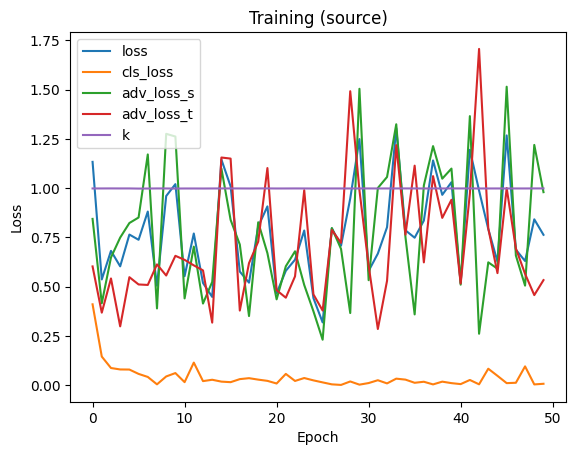

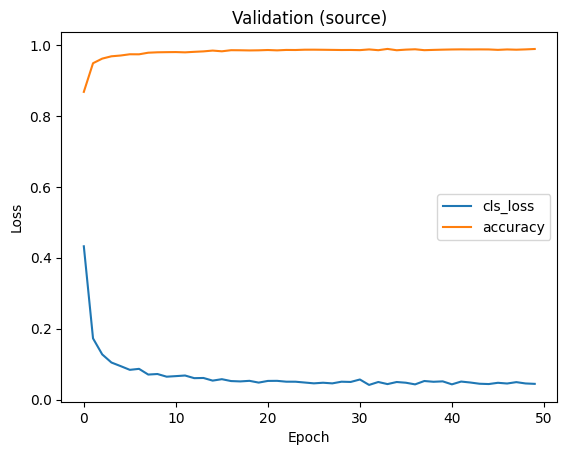

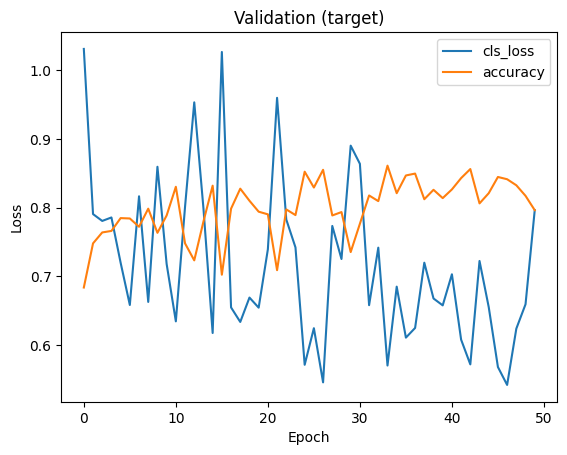

In [15]:
plot_losses(
    list(all_loss.T),
    loss_labels,
    ylabel='Loss',
    xlabel='Epoch',
    title='Training (source)'
)
plot_losses(
    list(all_loss_val_s.T),
    loss_labels_val,
    ylabel='Loss',
    xlabel='Epoch',
    title='Validation (source)'
)
plot_losses(
    list(all_loss_val_t.T),
    loss_labels_val,
    ylabel='Loss',
    xlabel='Epoch',
    title='Validation (target)'
)

In [16]:
classifier.load_state_dict(torch.load(model_save_path))
evaluate(classifier, test_s, cls_loss_fn, mode='Test (source)')
evaluate(classifier, test_t, cls_loss_fn, mode='Test (target)')

Test (source) -> cls_loss: 0.034100	accuracy: 98.9100%
Test (target) -> cls_loss: 0.734951	accuracy: 79.9701%


(0.7349507659673691, 0.7997010463378177)